In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os

import itertools

import random

import senepy as sp

In [2]:
import time
import numba as nb


In [3]:
adata = sc.read_h5ad('../../data/tms/tms-scVI-raw-data_BDATA.h5ad')

In [4]:
cell_counts = pd.read_pickle('../../data/files/5_ALL_GENE_cell_counts_TMS.pickle')

In [9]:
!mkdir permutation_output

#### we will create a null distribution based on random permutation of gene expression within genes
ie, gene values are shuffled acrross cells but not between genes

but make sure only shuffled within cell types

permutations are processed by do_mouse_permutations.py

In [5]:
def filter_cell_stats(df): #these are all fractions, not percents
    df = df[df.start < 0.05] #starts below 5%
    df = df[df.end < 0.2] #ends below 20%
    df = df[df.end > 0.01] #no genes that end below 1%
    
    df = df[df.gain > .005] #gains at least 0.5%
    df = df[(df.ratio > 2.5) | (df.gain > .05)] #raito of at least 2
    return df

def soft_filter(df): #soft filter to get rid of most values for faster calculations
    df = df[df.start < 0.1] #starts below 10%
    df = df[df.end < 0.4] #ends below 40%
    df = df[df.end > 0.01] #no genes that end below 1%
    
    df = df[df.gain > .005] #gains at least 0.5%
    df = df[(df.ratio > 1.5) | (df.gain > .025)]
    return df

In [3]:
#this makes it easier for multiprocessing so dont have to load entire adata each thread
# for thing in list(hubs.hubs):
#     tissue, cell = thing
#     cdata = adata[(adata.obs.tissue2 == tissue) &\
#                         (adata.obs.cell_type_2 == cell)]

#     f = f'temp_adata_subs/{tissue}_{cell}.h5ad'
#     f = f.replace(' ', '_')
#     cdata.write_h5ad(f)
#     print(f)

In [10]:
# #doing the same for additional mouse perms needed for Fig 1, the ones that don't have senepy signatures

# amp = pd.read_csv('additional_mouse_perms.csv', index_col=0)

# for tissue, cell in zip(amp.tissue, amp.cell_type_2):
#     cdata = adata[(adata.obs.tissue2 == tissue) &\
#                         (adata.obs.cell_type_2 == cell)]
#     f = f'temp_adata_subs/{tissue}_{cell}.h5ad'
#     f = f.replace(' ', '_')
#     cdata.write_h5ad(f)
#     print(f)

temp_adata_subs/Bladder_bladder_urothelial_cell.h5ad
temp_adata_subs/Kidney_collecting_duct_epithelial_cell.h5ad
temp_adata_subs/Large_Intestine_enterocyte.h5ad
temp_adata_subs/Limb_Muscle_endothelial_cell.h5ad
temp_adata_subs/Limb_Muscle_mesenchymal_stem_cell.h5ad
temp_adata_subs/Lung_adventitial_cell.h5ad
temp_adata_subs/Lung_smooth_muscle_cell.h5ad
temp_adata_subs/Lymphoid_naive_T_cell.h5ad
temp_adata_subs/Lymphoid_immature_T_cell.h5ad
temp_adata_subs/Mammary_Gland_endothelial_cell.h5ad
temp_adata_subs/Mammary_Gland_luminal_epithelial_cell_of_mammary_gland.h5ad
temp_adata_subs/Mammary_Gland_basal_cell.h5ad
temp_adata_subs/Mammary_Gland_macrophage.h5ad
temp_adata_subs/Mammary_Gland_stromal_cell.h5ad
temp_adata_subs/Myeloid_granulocyte.h5ad
temp_adata_subs/Myeloid_myloid_progenitor.h5ad


In [6]:
def get_stats(test):
    age_grouped = test.groupby('age', observed = True)
    
    # Create a lookup dictionary for counts and gene expression by age
    counts = age_grouped['Count'].first().to_dict()
    gene_expression = age_grouped.first().to_dict()
    
    ages = ['1m', '3m', '18m', '21m', '24m', '30m']
    out = []
    for gene in test.columns[4:]:
        if gene == 'age' or gene == 'Count':
            continue
        
        age_data = {}
        for age in ages:
            age_data[f'c{age}'] = counts.get(age, 0)
            age_data[f'f{age}'] = gene_expression.get(gene, {}).get(age, 0)
        
        # Compute young_start and old_end
        if age_data['c3m'] > 200:
            young_start = age_data['f3m']
        else:
            young_start = (age_data['c3m'] * age_data['f3m'] + age_data['c1m'] * age_data['f1m']) / (age_data['c3m'] + age_data['c1m'])


        #need fix for mammary because mammary is the only one without 24m and 30m, using 21m instead
        if age_data['c30m'] > 200:
            old_end = age_data['f30m']
        elif test.iloc[0].tissue2 != 'Mammary_Gland':
            old_end = (age_data['c30m'] * age_data['f30m'] + age_data['c24m'] * age_data['f24m']) / (age_data['c30m'] + age_data['c24m'])
        else:
            old_end = (age_data['c21m'] * age_data['f21m']) / (age_data['c21m'])

        
        # if age_data['c30m'] > 200:
        #     old_end = age_data['f30m']
        # else:
        #     old_end = (age_data['c30m'] * age_data['f30m'] + age_data['c24m'] * age_data['f24m']) / (age_data['c30m'] + age_data['c24m'])
    
        # Calculate old_gain and old_ratio
        old_gain = old_end - young_start
        old_ratio = old_end / young_start if young_start != 0 else 0
        
        # Append results to output
        out.append([gene, young_start, old_end, old_gain, old_ratio])
    
    # Convert the output to DataFrame
    out_df = pd.DataFrame(out, columns=['gene', 'start', 'end', 'gain', 'ratio'])

    return out_df


In [7]:
with open('better_input_list_mouse.txt', 'r') as f:
    input_list = [x.strip().split('.') for x in list(f) if 'unknown' not in x]

len(input_list)

62

In [56]:
#check progress
# hubs = sp.load_hubs(species='Mouse', sig_type='cell_type')
# input_list = [list(x) for x in list(hubs.hubs)]
# len(input_list)

47

In [62]:
files = ['permutation_output/' + x for x in os.listdir('permutation_output/')]
cpu = 0
for tissue, cell in input_list:
    r = [x for x in files if tissue in x and cell in x]
    print(tissue, cell, len(r))
    current = len(files)
    expected = len(input_list)* 1000
    if len(r) < 1000 and cpu < 40:
        cpu += 1
print("####")
print(f'Done {current} of {expected} ({round(current/expected * 100,1)}%)')
print(f'Using {cpu} cpu')

Limb_Muscle smooth muscle cell 1001
Myeloid monocyte 1001
Large_Intestine goblet cell 1001
Skin epidermal cell 1001
Heart_and_Aorta myocyte 1001
Lymphoid T cell 3003
Lung fibroblast 1001
Heart_and_Aorta endocardial cell 1001
Thymus thymocyte 1001
Diaphragm mesenchymal stem cell 1001
Kidney macrophage 1001
Skin basal cell of epidermis 11
Lung alveolar macrophage 1001
Bladder endothelial cell 1001
Heart_and_Aorta fibroblast 1001
Liver hepatocyte 1001
Liver Kupffer cell 1001
Fat endothelial cell 1001
Limb_Muscle mesenchymal stem cell 1001
Lymphoid naive T cell 1001
Trachea fibroblast 1001
Tongue keratinocyte 1001
Myeloid granulocyte 1001
Myeloid macrophage 1001
Brain microglial cell 11
Kidney fenestrated cell 1001
Large_Intestine secretory cell 1001
Kidney collecting duct principal cell 1001
Skin bulge keratinocyte 13
Large_Intestine crypt stem cell 29
Bladder bladder urothelial cell 1001
HSC hematopoietic stem cell 1001
Pancreas pancreatic ductal cell 1001
Kidney epithelial cell of proxi

In [60]:
files = ['permutation_output/' + x for x in os.listdir('permutation_output/')]
cpu = 0

the_things = list(zip(amp.tissue, amp.cell_type_2))

for tissue, cell in the_things:
    r = [x for x in files if tissue in x and cell in x]
    print(tissue, cell, len(r))
    current = len(files)
    expected = len(the_things)* 1000
    if len(r) < 1000 and cpu < 40:
        cpu += 1
print("####")
print(f'Done {current} of {expected} ({round(current/expected * 100,1)}%)')
print(f'Using {cpu} cpu')

Bladder bladder urothelial cell 119
Kidney collecting duct epithelial cell 214
Large_Intestine enterocyte 193
Limb_Muscle endothelial cell 163
Limb_Muscle mesenchymal stem cell 135
Lung adventitial cell 122
Lung smooth muscle cell 146
Lymphoid naive T cell 236
Lymphoid immature T cell 233
Mammary_Gland endothelial cell 137
Mammary_Gland luminal epithelial cell of mammary gland 98
Mammary_Gland basal cell 93
Mammary_Gland macrophage 151
Mammary_Gland stromal cell 106
Myeloid granulocyte 143
Myeloid myloid progenitor 183
####
Done 49520 of 16000 (309.5%)
Using 16 cpu


## weighted test

In [8]:

#cap ratio at 2.5 so that it doesn't skew the results largley for imputed or low starting counts
@nb.njit
def ratio_function(x):
    if x < 2.5:
        return x

    return 2.5
    
    


In [10]:

@nb.njit
def end_function(x): #or is this end function?
    x = x*100
    if x <= 0:
        return 0
    elif 0 < x <= 3:
        #return (1/3)*x
        return increasing_logistic_function(x, 2, 0)
    elif 3 < x <= 20:
        return 1
    elif 20 < x <= 100:
        return -(1/4)*x + 6 #y = 1 at 20
    else:
        return 0

@nb.njit
def gain_function(x):

    x = x*100
    if x < 5:
        return x/5
    
    if x > 15:
        return -x/5 + 4

    return 1

@nb.njit
def start_function(x):
    x = x*100
    if x < 5:
        return 1
    
    return -x/2 + 3.5



end_function(1)
ratio_function(1)
gain_function(1)
start_function(1)

-46.5

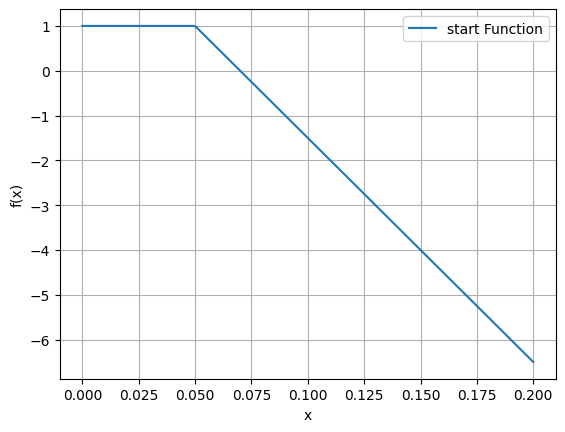

In [11]:
# start
test_values = np.linspace(0, .2, 200)
y_values = np.array([start_function(x) for x in test_values])

plt.plot(test_values, y_values, label='start Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()

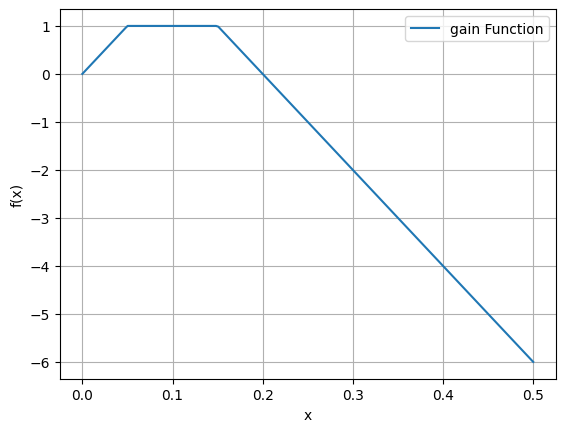

In [12]:
# gain
test_values = np.linspace(0, .5, 200)
y_values = np.array([gain_function(x) for x in test_values])

plt.plot(test_values, y_values, label='gain Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()

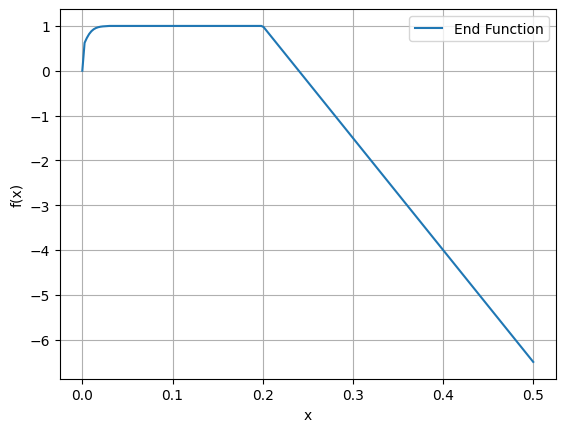

In [13]:
# end
test_values = np.linspace(0, 0.5, 200)
y_values = np.array([end_function(x) for x in test_values])

plt.plot(test_values, y_values, label='End Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.legend()
plt.show()

In [14]:
def jaccard_index(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return intersection / union

In [15]:

def filter_cell_stats(df): #OG filtering just for comparison purpose
    cf = df.copy()
    cf = cf[cf.start < 0.05] #starts below 5%
    cf = cf[cf.end < 0.2] #ends below 20%
    cf = cf[cf.end > 0.01] #no genes that end below 1%
    
    cf = cf[cf.gain > .005] #gains at least 0.5%
    cf = cf[(cf.ratio > 2.5) | (cf.gain > .05)] #raito of at least 2
    return df.gene.isin(cf.gene)

# def soft_stats(df):
#     df['soft_start'] = df.start.map(start_function)
#     df['soft_end'] = df.end.map(end_function)
#     df['soft_gain'] = df.gain.map(gain_function)
#     df['soft_ratio'] = df.ratio.map(ratio_function)

#     # df['soft_start'] = df['soft_start'].map(lambda x: round(x, 4))
#     # df['soft_end'] = df['soft_end'].map(lambda x: round(x, 4))

#     return df


def soft_stats(df):
    df['soft_start'] = np.vectorize(start_function)(df['start'].values)
    df['soft_end'] = np.vectorize(end_function)(df['end'].values)
    df['soft_gain'] = np.vectorize(gain_function)(df['gain'].values)
    df['soft_ratio'] = np.vectorize(ratio_function)(df['ratio'].values)

    # df['soft_start'] = df['soft_start'].map(lambda x: round(x, 4))
    # df['soft_end'] = df['soft_end'].map(lambda x: round(x, 4))

    return df

In [16]:
len(input_list)

62

In [48]:
#combine into feather for faster loading
for tissue, cell in tqdm(input_list):
    s = 'permutation_output/' + tissue + '.' + cell + '.feather'

    if not os.path.exists(s):
        perm_files = ['permutation_output/' + x for x in os.listdir('permutation_output/') if tissue in x and cell in x and 'feather' not in x]
        nulls = pd.concat([pd.read_csv(x, index_col=0) for x in perm_files]).reset_index(drop = True)
        nulls.to_feather(s)

100%|███████████████████████████████████████████| 62/62 [02:56<00:00,  2.85s/it]


In [75]:
add_list = [list(x) for x in zip(amp.tissue, amp.cell_type_2)]

#combine into feather for faster loading
for tissue, cell in tqdm(add_list):
    s = 'permutation_output/' + tissue + '.' + cell + '.feather'
    perm_files = ['permutation_output/' + x for x in os.listdir('permutation_output/') if tissue in x and cell in x]
    nulls = pd.concat([pd.read_csv(x, index_col=0) for x in perm_files]).reset_index(drop = True)
    nulls.to_feather(s)

100%|███████████████████████████████████████████| 16/16 [03:20<00:00, 12.55s/it]


In [62]:
#couple cell types had space at end and required this fix
cell_counts.cell_type_2 = cell_counts.cell_type_2.map(lambda x: x.strip())
adata.obs.cell_type_2 = adata.obs.cell_type_2.map(lambda x: x.strip())

In [332]:
#Trachea.fibroblast
#Skin.epidermal cell
#testers
#testers = [('Trachea', 'fibroblast'), ('Skin', 'epidermal cell')]

In [64]:
# def get_metric_p(x):
#     above_test = np.sum(metric_array > x)
#     return above_test / N

def calculate_p_values(null_array, test_values):
    sorted_null = np.sort(null_array)
    indices = np.searchsorted(sorted_null, test_values, side='right')
    p_values = (N - indices) / N
    return p_values

# hubs = sp.load_hubs(species='Mouse', sig_type='cell_type') #senepy v1
# input_list = [list(x) for x in list(hubs.hubs)]


res = []
for tissue, cell in tqdm(input_list):
#for tissue, cell in tqdm(add_list):
    
    # #load null files and combine
    # perm_files = ['permutation_output/' + x for x in os.listdir('permutation_output/') if tissue in x and cell in x]
    # nulls = pd.concat([pd.read_csv(x, index_col=0) for x in perm_files]).reset_index(drop = True)
    s = 'permutation_output/' + tissue + '.' + cell + '.feather'
    nulls = pd.read_feather(s)

    N = len(nulls)
    nulls = soft_stats(nulls)

    #load test data
    a = cell_counts[(cell_counts.tissue2 == tissue) &\
                (cell_counts.cell_type_2 == cell)].copy()

    #another fix for the additions. Some dont have representation in cell_counts so have to remake for them
    
    if len(a) == 0:
        sub = adata[(adata.obs.tissue2 == tissue) &\
                (adata.obs.cell_type_2 == cell)]
        
        _ = sub.obs.groupby(['age', 'tissue2', 'cell_type_2'])\
        .size().reset_index().rename(columns={0:'Count'})
        
        out = []
        for age_tissue_cell in tqdm(_.values):
            age_sub = adata[(adata.obs.age == age_tissue_cell[0]) &\
                            (adata.obs.tissue2 == age_tissue_cell[1]) &\
                            (adata.obs.cell_type_2 == age_tissue_cell[2])].X.toarray()
            col_out = []
            for gene in adata.var_names:
                i = np.where(adata.var_names == gene)[0][0]
                gene_vals = age_sub[:, i]
                gene_frac = len(gene_vals[gene_vals > 0])/len(gene_vals)
                if gene_frac == 0 and age_tissue_cell[0] in ['1m', '3m']: #only impute young
                    gene_frac = 1/len(gene_vals) #impute 1/num cells if value is 0
                
                col_out.append(gene_frac)
            out.append(col_out)
            
        a = pd.concat([_, pd.DataFrame(out, columns = list(adata.var_names))], axis = 1)
    
    
    a = get_stats(a)
    a = soft_stats(a)

    #combine values to create a comparable scaler
    # scaler = StandardScaler()
    # combined = np.vstack([nulls[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']],
    #                       a[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']]])
    # scaler = StandardScaler()
    # scaler.fit(combined)

    # #generate null metrics
    # nulls_scaled = scaler.transform(nulls[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']].values)
    # nulls['metric'] = np.sum(nulls_scaled, axis=1)

    # #generate test metrics
    # a_scaled = scaler.transform(a[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']].values)
    # a['metric'] = np.sum(a_scaled, axis=1)

    ##################### testing this
    nulls['metric'] = nulls[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']].sum(axis = 1)
    a['metric'] = a[['soft_gain', 'soft_ratio', 'soft_start', 'soft_end']].sum(axis = 1)
    #######################

    #determine p value based on location in null distribution
    #metric_array = nulls['metric'].to_numpy()
    a['p'] = calculate_p_values(nulls['metric'].to_numpy(), a['metric'].to_numpy())
    #a['p'] = a.metric.map(get_metric_p)ada

    #BH correction
    a = a.sort_values('metric', ascending = False)
    a['BH'] = a['p'] * len(a) / (a.reset_index().index + 1)
    a['BH'] = a['BH'].clip(upper=1)
    a = a.reset_index(drop = True)

    #just adding if it would have been filtered based on OG filter
    a['OrigFilt'] = filter_cell_stats(a)

    a['tissue_cell'] = tissue + '.' + cell
    res.append(a)

    


100%|█████████████████████████████████████████| 62/62 [1:14:17<00:00, 71.89s/it]


In [65]:
df = pd.concat(res)

In [66]:
df

gene     start       end      gain     ratio  soft_start  soft_end  \
0       Gsta4  0.027542  0.102210  0.074668  3.711007         1.0       1.0   
1        Gcc2  0.040254  0.104972  0.064718  2.607735         1.0       1.0   
2       Slfn8  0.012712  0.063536  0.050824  4.998158         1.0       1.0   
3       Ch25h  0.029661  0.088398  0.058737  2.980268         1.0       1.0   
4      Gabrr1  0.016949  0.082873  0.065924  4.889503         1.0       1.0   
...       ...       ...       ...       ...       ...         ...       ...   
20111   Rpl37  1.000000  1.000000  0.000000  1.000000       -46.5     -19.0   
20112   Cox5b  1.000000  1.000000  0.000000  1.000000       -46.5     -19.0   
20113    Ftl1  1.000000  1.000000  0.000000  1.000000       -46.5     -19.0   
20114  Cox4i1  1.000000  1.000000  0.000000  1.000000       -46.5     -19.0   
20115   Cox7c  1.000000  1.000000  0.000000  1.000000       -46.5     -19.0   

       soft_gain  soft_ratio  metric         p        BH  OrigFilt  \
0            1.0         2.5     5.5  0.000000  0.000000      True   
1            1.0         2.5     5.5  0.000000  0.000000      True   
2            1.0         2.5     5.5  0.000000  0.000000      True   
3            1.0         2.5     5.5  0.000000  0.000000      True   
4            1.0         2.5     5.5  0.000000  0.000000      True   
...          ...         ...     ...       ...       ...       ...   
20111        0.0         1.0   -64.5  0.997735  0.997933     False   
20112        0.0         1.0   -64.5  0.997735  0.997883     False   
20113        0.0         1.0   -64.5  0.997735  0.997834     False   
20114        0.0         1.0   -64.5  0.997735  0.997784     False   
20115        0.0         1.0   -64.5  0.997735  0.997735     False   

                                             tissue_cell  
0                         Limb_Muscle.smooth muscle cell  
1                         Limb_Muscle.smooth muscle cell  
2                         Limb_Muscle.smooth muscle cell  
3                         Limb_Muscle.smooth muscle cell  
4                         Limb_Muscle.smooth muscle cell  
...                                                  ...  
20111  Kidney.Henle thick ascending limb epithelial cell  
20112  Kidney.Henle thick ascending limb epithelial cell  
20113  Kidney.Henle thick ascending limb epithelial cell  
20114  Kidney.Henle thick ascending limb epithelial cell  
20115  Kidney.Henle thick ascending limb epithelial cell  

[1247192 rows x 14 columns]

In [68]:
df.to_csv('mouse_gene_stats_fin.csv')

In [392]:
print('BH', '\t' ,'orig', '\t' , 'og+BH', '\t' ,'og+p', '\t' , 'j', '\t' , 'tissue.cell')
#for tissue, cell in input_list:
for tissue, cell in testers:
    s = tissue + '.' + cell
    _ = df[df.tissue_cell == s]

    sig = _[_.BH < 0.1]
    just_p = _[_.p < 0.1]
    orig = _[_.OrigFilt]
    orig_p = just_p[just_p.gene.isin(orig.gene)]
    orig_sig = sig[sig.gene.isin(orig.gene)]

    j = jaccard_index(set(orig.gene), set(sig.gene))

    
    print(len(sig), '\t' ,len(orig), '\t' , len(orig_sig), '\t' , len(orig_p) , '\t', round(j, 2), '\t' , s)

BH 	 orig 	 og+BH 	 og+p 	 j 	 tissue.cell
1292 	 945 	 945 	 945 	 0.73 	 Trachea.fibroblast
7 	 183 	 6 	 183 	 0.03 	 Skin.epidermal cell


In [334]:
print('BH', '\t' ,'orig', '\t' , 'og+BH', '\t' ,'og+p', '\t' , 'j', '\t' , 'tissue.cell')
#for tissue, cell in input_list:
for tissue, cell in testers:
    s = tissue + '.' + cell
    _ = df[df.tissue_cell == s]

    sig = _[_.BH < 0.1]
    just_p = _[_.p < 0.1]
    orig = _[_.OrigFilt]
    orig_p = just_p[just_p.gene.isin(orig.gene)]
    orig_sig = sig[sig.gene.isin(orig.gene)]

    j = jaccard_index(set(orig.gene), set(sig.gene))

    
    print(len(sig), '\t' ,len(orig), '\t' , len(orig_sig), '\t' , len(orig_p) , '\t', round(j, 2), '\t' , s)

BH 	 orig 	 og+BH 	 og+p 	 j 	 tissue.cell
1292 	 945 	 945 	 945 	 0.73 	 Trachea.fibroblast
7 	 183 	 6 	 183 	 0.03 	 Skin.epidermal cell


In [253]:
#df = pd.concat(res)

In [255]:
#df.to_csv('mouse_gene_stats_v2.csv')

In [69]:
df = pd.read_csv('mouse_gene_stats_fin.csv', index_col=0)

In [70]:
sel = {}
for c in df.tissue_cell.unique():
    _ = df[df.tissue_cell == c]
    selected = _[(_.BH < 0.05) | ((_.OrigFilt) & (_.p < .01))]
    a = set(_[_.OrigFilt].gene)
    b = set(selected.gene)
    i = a.intersection(b)
    d = len(b) - len(a)

    p = stats.hypergeom.sf(len(i), len(_), len(a), len(b))

    sel[c] = list(b)
    
    print(f'{len(a)}\t{len(b)}\t{len(i)}\t{d}\t{p}')

264	182	182	-82	0.0
51	94	51	43	0.0
83	84	83	1	0.0
183	43	42	-140	8.342219195505278e-91
784	433	433	-351	0.0
154	466	154	312	0.0
1069	994	951	-75	0.0
662	417	417	-245	0.0
692	1216	692	524	0.0
912	293	293	-619	0.0
435	435	435	0	0.0
48	48	48	0	0.0
383	159	159	-224	0.0
180	93	93	-87	0.0
190	276	190	86	0.0
1239	1750	1239	511	0.0
2670	4450	2670	1780	0.0
397	523	397	126	0.0
55	65	55	10	0.0
70	70	70	0	0.0
945	1139	945	194	0.0
231	594	231	363	0.0
16	23	16	7	0.0
577	225	225	-352	0.0
44	133	44	89	0.0
575	270	270	-305	0.0
230	93	93	-137	0.0
1193	1361	1193	168	0.0
27	28	27	1	0.0
36	36	36	0	0.0
13	16	13	3	0.0
293	366	293	73	0.0
116	53	53	-63	0.0
312	206	206	-106	0.0
67	67	67	0	0.0
725	333	333	-392	0.0
87	154	87	67	0.0
672	489	489	-183	0.0
77	22	22	-55	0.0
28	29	28	1	0.0
116	117	116	1	0.0
777	959	743	182	0.0
67	74	67	7	0.0
95	71	71	-24	0.0
313	156	156	-157	0.0
962	515	512	-447	0.0
2316	1402	1317	-914	0.0
163	50	50	-113	0.0
172	191	172	19	0.0
71	52	52	-19	0.0
160	399	160	239	0.0
405	326	325	-79	0.0
1

In [49]:
ls ../../data/

all_cells_scvi.h5ad  FIG_1B_null.npy  lethal_covid/  PBMC_COVID/  tms/
annotations/         files/           p16_td_pos/    senolytics/
bulk_RNAseq/         gene_lists/      parabiosis/    spatial/


In [72]:
import pickle

In [73]:
#these are saved and imported in notebook 5 for further processing
with open('../../data/files/R1_FILT_GENES_MOUSE.pickle', 'wb') as f:
    pickle.dump(sel, f)